<a href="https://colab.research.google.com/github/aboelela924/Deep-learning-with-TF2-and-Keras/blob/master/Deep_learning_with_TF2_and_Keras_chapter_06_Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>MNIST Fully Connect GAN</h1>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = (X_train - 127.5) / 127.5

In [4]:
BATCH_SIZE = 128
EPOCHS = 200
NOISE_LENGTH = 10
IMG_WIDTH = 28
IMG_HEIGHT = 28

In [5]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
loss_function = "binary_crossentropy"

In [6]:
discriminator =  Sequential()
discriminator.add(Dense(1024,  input_shape=(IMG_HEIGHT*IMG_HEIGHT, )))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation="sigmoid"))

In [7]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [8]:
discriminator.compile(optimizer=optimizer, loss=loss_function)

In [9]:
generator = Sequential()
generator.add(Dense(256, input_shape=(NOISE_LENGTH, )))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(IMG_WIDTH*IMG_HEIGHT, activation="tanh"))

In [10]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)              

In [11]:
discriminator.trainable = False

gan_in = Input(shape=(NOISE_LENGTH, ), batch_size=BATCH_SIZE)
gen_out = generator(gan_in)
dis_out = discriminator(gen_out)

gan = Model(inputs=gan_in, outputs=dis_out)

In [12]:
gan.compile(optimizer=optimizer, loss=loss_function)

In [13]:
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 10)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1463312   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [14]:
def train(epochs=20, batch_size=128):
    batchs_count_per_epoch = int(X_train.shape[0] / batch_size)
    dlosses = []
    glosses = []
    for e in range(epochs):
        for b in range(batchs_count_per_epoch):
            
            discriminator.trainable = True
            dis_noise = np.random.normal(0, 1, size=[batch_size, NOISE_LENGTH])
            dis_fake_images = generator.predict(dis_noise)
            dis_real_images = X_train[b*batch_size:(b+1)*batch_size]
            dis_real_images = dis_real_images.reshape(dis_real_images.shape[0], IMG_HEIGHT*IMG_WIDTH)
            dis_in = np.concatenate([dis_real_images, dis_fake_images])
            dis_labels = np.zeros(2*batch_size)
            dis_labels[:batch_size] = 0.9
            dloss = discriminator.train_on_batch(dis_in, dis_labels)

            discriminator.trainable = False
            gen_noise = np.random.normal(0, 1, size=[batch_size, NOISE_LENGTH])
            gen_labels = np.ones(batch_size)
            gloss = gan.train_on_batch(gen_noise, gen_labels)

        print(f"Epoch :{e+1}, Discriminator loss: {dloss}, Generator loss: {gloss}")
        dlosses.append(dloss)
        glosses.append(gloss)
    return dlosses, glosses

dlosses, glosses = train(EPOCHS, BATCH_SIZE)

Epoch :1, Discriminator loss: 0.5580607652664185, Generator loss: 1.4038292169570923
Epoch :2, Discriminator loss: 0.4475633502006531, Generator loss: 1.5859318971633911
Epoch :3, Discriminator loss: 0.4322492480278015, Generator loss: 2.165348529815674
Epoch :4, Discriminator loss: 0.43786346912384033, Generator loss: 2.5386266708374023
Epoch :5, Discriminator loss: 0.5014641880989075, Generator loss: 1.954221487045288
Epoch :6, Discriminator loss: 0.4659395217895508, Generator loss: 1.7892706394195557
Epoch :7, Discriminator loss: 0.4835607409477234, Generator loss: 1.9561855792999268
Epoch :8, Discriminator loss: 0.550843358039856, Generator loss: 1.8084677457809448
Epoch :9, Discriminator loss: 0.5523859858512878, Generator loss: 1.592792272567749
Epoch :10, Discriminator loss: 0.5903322696685791, Generator loss: 1.298754334449768
Epoch :11, Discriminator loss: 0.5835232734680176, Generator loss: 1.4606573581695557
Epoch :12, Discriminator loss: 0.5796564817428589, Generator loss: 

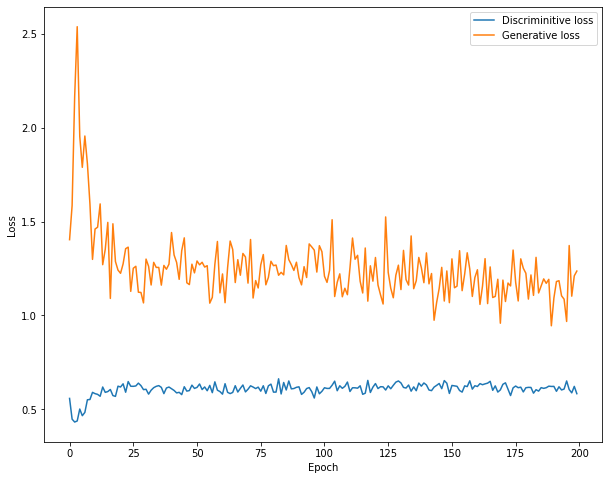

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(dlosses, label='Discriminitive loss')
plt.plot(glosses, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

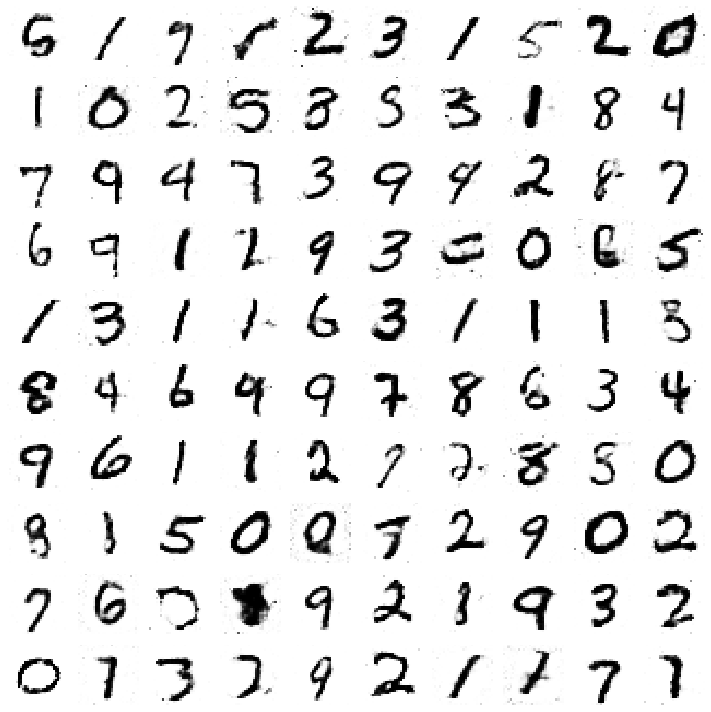

In [19]:
noise = np.random.normal(0, 1, size=[100, NOISE_LENGTH])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(100, 28, 28)
plt.figure(figsize=(10,10))
for i in range(generatedImages.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()